# ELAIS-N1 master catalogue
## Preparation of Spitzer datafusion SWIRE data

The Spitzer catalogues were produced by the datafusion team are available in `dmu0_DataFusion-Spitzer`.
Lucia told that the magnitudes are aperture corrected.

In the catalouge, we keep:

We keep:
- The internal identifier (this one is only in HeDaM data);
- The position;
- The fluxes in aperture 2 (1.9 arcsec) for IRAC bands.
- The Kron flux;
- The stellarity in each band

A query of the position in the Spitzer heritage archive show that the ELAIS-N1 images were observed in 2004. Let's take this as epoch.

We do not use the MIPS fluxes as they will be extracted on MIPS maps using XID+.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
284b2ef (Mon Aug 14 20:02:12 2017 +0100)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "swire_ra"
DEC_COL = "swire_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'internal_id': "swire_intid",
        'ra_spitzer': "swire_ra",
        'dec_spitzer': "swire_dec",
        'flux_ap2_36': "f_ap_swire_irac_i1",
        'uncf_ap2_36': "ferr_ap_swire_irac_i1",
        'flux_kr_36': "f_swire_irac_i1",
        'uncf_kr_36': "ferr_swire_irac_i1",
        'stell_36': "swire_stellarity_irac_i1",
        'flux_ap2_45': "f_ap_swire_irac_i2",
        'uncf_ap2_45': "ferr_ap_swire_irac_i2",
        'flux_kr_45': "f_swire_irac_i2",
        'uncf_kr_45': "ferr_swire_irac_i2",
        'stell_45': "swire_stellarity_irac_i2",
        'flux_ap2_58': "f_ap_irac_i3",
        'uncf_ap2_58': "ferr_ap_irac_i3",
        'flux_kr_58': "f_irac_i3",
        'uncf_kr_58': "ferr_irac_i3",
        'stell_58': "swire_stellarity_irac_i3",
        'flux_ap2_80': "f_ap_irac_i4",
        'uncf_ap2_80': "ferr_ap_irac_i4",
        'flux_kr_80': "f_irac_i4",
        'uncf_kr_80': "ferr_irac_i4",
        'stell_80': "swire_stellarity_irac_i4",
    })


catalogue = Table.read("../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SWIRE_ELAIS-N1.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2004

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding magnitude and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        
        magnitude, error = flux_to_mag(
            np.array(catalogue[col])/1.e6, np.array(catalogue[errcol])/1.e6)
        # Note that some fluxes are 0.
        
        catalogue.add_column(Column(magnitude, name="m{}".format(col[1:])))
        catalogue.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))


/home/yroehlly/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


In [6]:
catalogue[:10].show_in_notebook()

idx,swire_intid,swire_ra,swire_dec,f_ap_swire_irac_i1,ferr_ap_swire_irac_i1,f_swire_irac_i1,ferr_swire_irac_i1,swire_stellarity_irac_i1,f_ap_swire_irac_i2,ferr_ap_swire_irac_i2,f_swire_irac_i2,ferr_swire_irac_i2,swire_stellarity_irac_i2,f_ap_irac_i3,ferr_ap_irac_i3,f_irac_i3,ferr_irac_i3,swire_stellarity_irac_i3,f_ap_irac_i4,ferr_ap_irac_i4,f_irac_i4,ferr_irac_i4,swire_stellarity_irac_i4,m_ap_swire_irac_i1,merr_ap_swire_irac_i1,m_swire_irac_i1,merr_swire_irac_i1,flag_swire_irac_i1,m_ap_swire_irac_i2,merr_ap_swire_irac_i2,m_swire_irac_i2,merr_swire_irac_i2,flag_swire_irac_i2,m_ap_irac_i3,merr_ap_irac_i3,m_irac_i3,merr_irac_i3,flag_irac_i3,m_ap_irac_i4,merr_ap_irac_i4,m_irac_i4,merr_irac_i4,flag_irac_i4
,,deg,deg,uJy,uJy,uJy,uJy,,uJy,uJy,uJy,uJy,,uJy,uJy,uJy,uJy,,uJy,uJy,uJy,uJy,,,,,,,,,,,,,,,,,,,,,
0,584549,246.55273,54.990584,15.81,1.34,17.25,1.63,0.46,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.9026703252,0.09202318244,20.8080272515,0.102594203696,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
1,584511,246.552,54.989464,14.17,1.32,18.1,4.47,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,21.0215753744,0.101141269603,20.7558035628,0.268134852777,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
2,584278,246.54063,54.987334,73.12,1.49,53.62,1.05,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.2399095432,0.0221245479361,19.5766829759,0.0212611528347,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
3,584143,246.54075,54.982384,19.24,4.02,21.8,7.48,0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.6894873307,0.226853406607,20.553858766,0.372537009706,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
4,583979,246.53593,54.980094,67.47,2.05,49.99,1.62,0.99,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.3272232246,0.0329888723841,19.6527921581,0.0351848900122,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
5,583513,246.52083,54.972094,25.5,1.5,26.51,1.62,0.62,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.3836495489,0.063866835574,20.3414756807,0.0663482705284,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
6,583700,246.5251,54.976784,55.04,1.53,55.97,1.75,0.77,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,19.5483039369,0.0301812571453,19.5301117327,0.0339474425286,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
7,583609,246.52057,54.976004,7.1,0.81,6.59,0.82,0.49,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,21.7718541282,0.123865679698,21.8527864635,0.135099193915,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
8,583539,246.51503,54.976924,23.25,1.03,18.98,0.98,0.81,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.4839426069,0.0480992813291,20.7042594798,0.0560601412362,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['ferr_ap_swire_irac_i1', 'ferr_ap_swire_irac_i2', 'ferr_ap_irac_i3', 'ferr_ap_irac_i4']
FLAG_NAME = "swire_flag_cleaned"

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 573843 sources.
The cleaned catalogue has 573794 sources (49 removed).
The cleaned catalogue has 49 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_ELAIS-N1.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

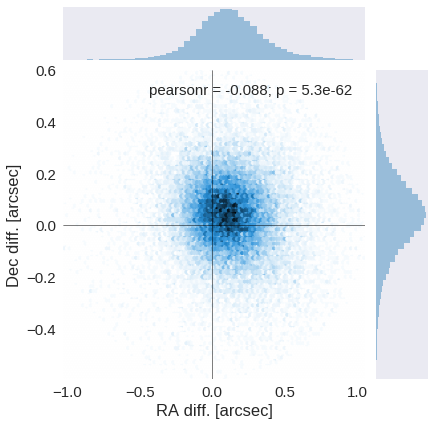

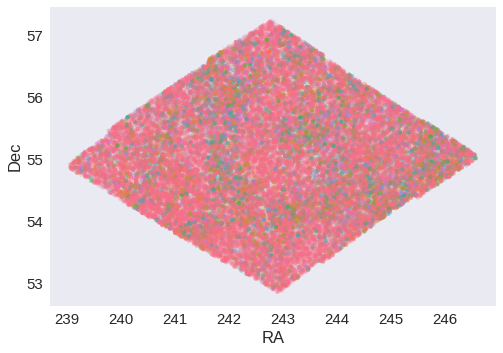

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.11121544077354883 arcsec
Dec correction: -0.04267586375164001 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

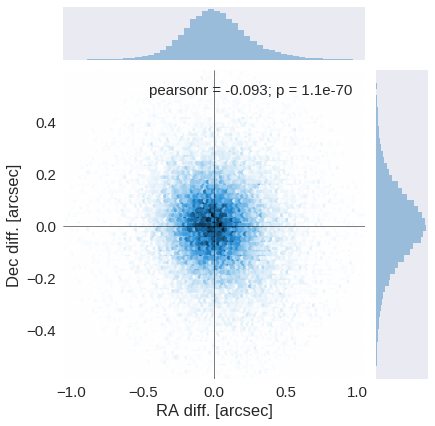

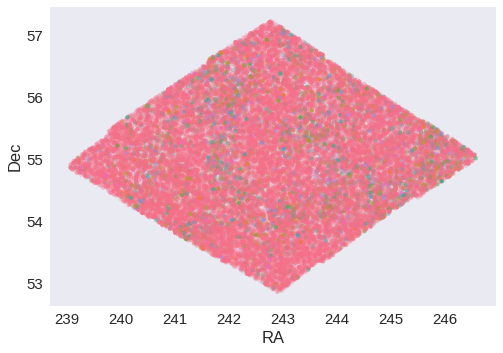

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "swire_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

37537 sources flagged.


# V - Saving to disk

In [15]:
catalogue.write("{}/SWIRE.fits".format(OUT_DIR), overwrite=True)